## Choosing Event Thresholds

Joo & Frank ., et al., (2018) notes that as the distribution of ripple power is lognormal and not bimodal it follows that “application of a threshold to ripple power…should not be understood as discriminating between SWR and non-SWR events with perfect accuracy”.  We have attempted to collate information from the literature around how to set these thresholds (Liu et al., 2022).  Here we also present some exploratory data analyses one can perform as sanity checks on their thresholds.  To our knowledge the use of phase amplitude coupling between sharp wave phase and ripple amplitude during coinciden times represents a novel method for data quality checking.

Joo, H. R. & Frank, L. M. The hippocampal sharp wave-ripple in memory retrieval for immediate use and consolidation. Nat. Rev. Neurosci. 19, 744–757 (2018).

Liu, A. A., Henin, S., Abbaspoor, S., Bragin, A., Buffalo, E. A., Farrell, J. S., ... & Buzsáki, G. (2022). A consensus statement on detection of hippocampal sharp wave ripples and differentiation from other fast oscillations. Nature communications, 13(1), 6000.

# Understanding Threshold Selection in Sharp Wave Ripple Detection

## Data Infrastructure for Dataset-Level Analyses

This notebook demonstrates how to build a robust data infrastructure for comprehensive SWR analyses across multiple datasets. The `SharpWaveComponentPlotter` object we create here serves as a foundation for collecting, storing, and accessing all SWR-related data in a structured manner.

### Key Benefits of This Approach

**Centralized Data Management**: The object organizes data hierarchically (dataset → session → probe → event_type), making it easy to access specific subsets of data for analysis while maintaining the ability to perform cross-dataset comparisons.

**Scalable Architecture**: This structure can be extended to incorporate additional data types, such as:
- **Spiking data**: Unit activity, firing rates, spike timing relative to SWRs
- **Behavioral data**: Running speed, pupil diameter, task performance, reward timing
- **Physiological data**: LFP from other brain regions, EMG, heart rate

### Foundation for Hypothesis Testing

This infrastructure enables sophisticated analyses using Generalized Linear Models (GLMs) to test hypotheses about:
- How SWR characteristics relate to behavioral states
- The relationship between spiking activity and SWR properties
- Cross-regional interactions during SWR events
- Temporal dynamics of SWR occurrence relative to task events

### Critical Statistical Considerations

**⚠️ Important Reminder**: While this notebook focuses on exploratory data analysis (EDA), any formal hypothesis testing using this data infrastructure requires:

1. **Bootstrapping**: For estimating confidence intervals and assessing the stability of parameter estimates
2. **Multiple Comparisons Correction**: When testing multiple hypotheses (e.g., across different brain regions, time windows, or behavioral conditions)
3. **Cross-validation**: To ensure results generalize beyond the specific dataset
4. **Effect size reporting**: Beyond just p-values, report meaningful effect sizes

**Note**: We do not implement these statistical safeguards in this EDA notebook, but they are essential for any formal analysis using this data structure.

---

## The Fundamental Challenge: Continuous vs. Discrete Definitions

As Joo & Frank (2018) note, **"the distribution of ripple power is lognormal and not bimodal"**, which means that **"application of a threshold to ripple power…should not be understood as discriminating between SWR and non-SWR events with perfect accuracy"**. This observation highlights a fundamental challenge in SWR detection: we are attempting to impose discrete boundaries on what is inherently a continuous phenomenon.

In [ ]:
# Set the path to the SWR data here
# This notebook only uses the SWR data, so no need to set a cache dir for the api/sdk
# uses all datasets in the SWR data
SWR_INPUT_DIR = "/your/path/to/SWR_final_pipeline"

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
import gzip
import json
from scipy.signal import fftconvolve

class SharpWaveComponentPlotter:
    """
    Class for loading and organizing Sharp Wave Ripple (SWR) data.
    
    The class organizes data in a hierarchical structure:
    - dataset
        - session_id
            - probe_id
                - event_type (putative_swr_events, gamma_band_events, movement_artifacts)
    """
    
    def __init__(self, base_path):
        """
        Initialize with the base path where data is stored.
        
        Parameters:
        -----------
        base_path : str
            Path to the directory containing the datasets
        """
        self.base_path = base_path
        self.data = {}
        self.event_types = {
            'putative_swr_events',
            'gamma_band_events', 
            'movement_artifacts',
            'probe_metadata',
            'global_swr_events',
            'session_metadata',
            'channel_selection_metadata',
            'run_settings'
        }
    
    def _parse_filename(self, filepath):
        """
        Parse filename to extract components (probe_id, channel_id, event_type).
        
        Parameters:
        -----------
        filepath : str
            Path to the file
            
        Returns:
        --------
        tuple : (probe_id, channel_id, event_type, file_format)
        """
        filename = os.path.basename(filepath)
        
        # Determine file format
        if filename.endswith('.json.gz'):
            file_format = 'json'
        elif filename.endswith('.csv.gz') or filename.endswith('.csv'):
            file_format = 'csv'
        else:
            return None, None, None, None
        
        # Extract probe ID (when present)
        probe_match = re.search(r'probe_(\d+)', filename)
        probe_id = probe_match.group(1) if probe_match else None
        
        # Extract channel ID (for CSV files)
        channel_id = None
        if file_format == 'csv':
            channel_match = re.search(r'channel_([^_]+)', filename)
            channel_id = channel_match.group(1) if channel_match else None
            
            # Special case for channelsrawInd
            if channel_id == 'channelsrawInd':
                channel_raw_match = re.search(r'channelsrawInd_(\d+)', filename)
                if channel_raw_match:
                    channel_id = f"channelsrawInd_{channel_raw_match.group(1)}"
        
        # Determine event/data type
        event_type = None
        
        # CSV event types
        csv_types = ['putative_swr_events', 'gamma_band_events', 'movement_artifacts']
        for et in csv_types:
            if et in filename:
                event_type = et
                break
        
        # CSV metadata types
        if event_type is None:
            if 'probe_metadata' in filename:
                event_type = 'probe_metadata'
            elif 'global_swr_events' in filename:
                event_type = 'global_swr_events'
            elif 'session_metadata' in filename:
                event_type = 'session_metadata'
        
        # JSON types
        if file_format == 'json':
            if 'channel_selection_metadata' in filename:
                event_type = 'channel_selection_metadata'
            elif 'run_settings' in filename:
                event_type = 'run_settings'
        
        return probe_id, channel_id, event_type, file_format
    
    def load_data(self, dataset_name, session_ids=None):
        """
        Load data from the specified dataset and session IDs.
        
        Parameters:
        -----------
        dataset_name : str
            Name of the dataset directory
        session_ids : list, optional
            List of session IDs to load. If None, all sessions are loaded.
        
        Returns:
        --------
        self : for method chaining
        """
        dataset_path = os.path.join(self.base_path, dataset_name)
        
        if not os.path.exists(dataset_path):
            raise ValueError(f"Dataset path does not exist: {dataset_path}")
        
        # Initialize dataset in the data structure if it doesn't exist
        if dataset_name not in self.data:
            self.data[dataset_name] = {}
            
        # Get all session directories if session_ids is None
        if session_ids is None:
            session_dirs = glob.glob(os.path.join(dataset_path, "swrs_session_*"))
            session_ids = [os.path.basename(d).split('_')[-1] for d in session_dirs]
        
        # Loop through each session
        for session_id in tqdm(session_ids, desc="Loading sessions"):
            session_path = os.path.join(dataset_path, f"swrs_session_{session_id}")
            
            if not os.path.exists(session_path):
                print(f"Warning: Session path does not exist: {session_path}")
                continue
            
            # Initialize session in the data structure
            if session_id not in self.data[dataset_name]:
                self.data[dataset_name][session_id] = {}
            
            # Find all files in the session directory (CSV and JSON)
            all_files = glob.glob(os.path.join(session_path, "*.csv*")) + \
                    glob.glob(os.path.join(session_path, "*.json.gz"))
            
            # Process each file
            for file_path in all_files:
                try:
                    # Parse filename to get components
                    probe_id, channel_id, event_type, file_format = self._parse_filename(file_path)
                    
                    if not event_type:
                        # Silently skip files that don't match our expected patterns
                        continue
                    
                    # Use 'session_level' for session-wide files (no probe_id)
                    storage_probe_id = probe_id if probe_id else 'session_level'
                    
                    # Initialize probe/session_level in the data structure
                    if storage_probe_id not in self.data[dataset_name][session_id]:
                        self.data[dataset_name][session_id][storage_probe_id] = {}
                    
                    # Load file based on format
                    if file_format == 'csv':
                        df = pd.read_csv(file_path, compression="gzip")
                        self.data[dataset_name][session_id][storage_probe_id][event_type] = df
                    elif file_format == 'json':
                        with gzip.open(file_path, 'rt') as f:
                            json_data = json.load(f)
                        self.data[dataset_name][session_id][storage_probe_id][event_type] = json_data
                    
                    # Optional: uncomment for debugging
                    # print(f"Loaded: {file_path}")
                    
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    continue
        
        return self

    def get_data(self, dataset_name=None, session_id=None, probe_id=None, event_type=None):
        """
        Retrieve loaded data from object based on specified parameters.
        
        Parameters:
        -----------
        dataset_name : str, optional
            Name of the dataset
        session_id : str, optional
            Session ID
        probe_id : str, optional
            Probe ID
        event_type : str, optional
            Event type
        
        Returns:
        --------
        pd.DataFrame or dict
            Data that matches the specified parameters
        """
        # Start with the full data dict
        result = self.data
        
        # Filter by dataset_name
        if dataset_name is not None:
            if dataset_name not in result:
                raise ValueError(f"Dataset '{dataset_name}' not found")
            result = result[dataset_name]
            
            # Filter by session_id
            if session_id is not None:
                if session_id not in result:
                    raise ValueError(f"Session '{session_id}' not found in dataset '{dataset_name}'")
                result = result[session_id]
                
                # When probe_id not specified but event_type is
                if probe_id is None and event_type is not None:
                    # Create a list to hold matching dataframes
                    event_dfs = []
                    # Loop through all probes in this session
                    for probe in result.keys():
                        for event in result[probe].keys():
                            if event == event_type:
                                event_dfs.append(result[probe][event])
                    # Return the list of dataframes
                    return event_dfs
                
                # Filter by probe_id
                if probe_id is not None:
                    if probe_id not in result:
                        raise ValueError(f"Probe '{probe_id}' not found in session '{session_id}'")
                    result = result[probe_id]
                    
                    # Filter by event_type
                    if event_type is not None:
                        if event_type not in result:
                            raise ValueError(f"Event type '{event_type}' not found for probe '{probe_id}'")
                        result = result[event_type]
        
        return result

    def _format_label(self, label):
        """Format column names for better display."""
        return ' '.join(word.upper() if len(word) <= 3 else word.capitalize() for word in label.replace('_', ' ').split())
    
    def plot_swr_events(self, dataset_name, session_ids=None, x_col='power_max_zscore', y_col='sw_peak_power', 
                        color_by_overlap=True, x_threshold=None, y_threshold=None, alpha=0.7,
                        figsize=(12, 8), title=None, xlabel=None, ylabel=None, legend=True,
                        plot_name=None):
        """
        Create a scatter plot of SWR events (putative_swr_events) and store the concatenated data.
        
        Parameters:
        -----------
        dataset_name : str
            Name of the dataset
        session_ids : list or str, optional
            Single session ID or list of session IDs to include. If None, all loaded sessions are used.
        x_col : str, default='max_zscore'
            Column name for x-axis
        y_col : str, default='sw_peak_power'
            Column name for y-axis
        color_by_overlap : bool, default=True
            Whether to color points by their overlap with gamma and movement events
        x_threshold : float or list, optional
            Value(s) for vertical threshold line(s)
        y_threshold : float or list, optional
            Value(s) for horizontal threshold line(s)
        alpha : float, default=0.7
            Transparency of points
        figsize : tuple, default=(12, 8)
            Figure size as (width, height)
        title : str, optional
            Plot title (if None, a default title will be generated)
        xlabel : str, optional
            X-axis label (if None, x_col will be used)
        ylabel : str, optional
            Y-axis label (if None, y_col will be used)
        legend : bool, default=True
            Whether to show the legend
        plot_name : str, optional
            Name to identify this plot in the stored plotlist dictionary.
            If None, a name will be generated based on dataset and session.
            
        Returns:
        --------
        fig, ax : tuple
            Matplotlib figure and axis objects
        """

        
        # Initialize the plotlist if it doesn't exist
        if not hasattr(self, 'plotlist'):
            self.plotlist = {}
        
        # Handle single session ID
        if isinstance(session_ids, str):
            session_ids = [session_ids]
        
        # Get all karlsson events data
        all_dfs = []
        
        if session_ids is None:
            # Get all sessions if none specified
            if dataset_name in self.data:
                session_ids = list(self.data[dataset_name].keys())
            else:
                raise ValueError(f"Dataset '{dataset_name}' not found")
        
        # Collect data from all requested sessions
        for session_id in session_ids:
            event_dfs = self.get_data(dataset_name, session_id, event_type='putative_swr_events')
            if event_dfs:  # Add to list if not empty
                all_dfs.extend(event_dfs)
        
        if not all_dfs:
            raise ValueError("No putative_swr_events data found for the specified sessions")
        
        # Concatenate all dataframes
        data = pd.concat(all_dfs, ignore_index=True)
        
        # Generate plot name if not provided
        if plot_name is None:
            if len(session_ids) == 1:
                plot_name = f"{dataset_name}_session_{session_ids[0]}_{x_col}_vs_{y_col}"
            else:
                plot_name = f"{dataset_name}_multiple_sessions_{x_col}_vs_{y_col}"
        
        # Store the data in the plotlist
        self.plotlist[plot_name] = {
            'data': data,
            'params': {
                'dataset_name': dataset_name,
                'session_ids': session_ids,
                'x_col': x_col,
                'y_col': y_col,
                'x_threshold': x_threshold,
                'y_threshold': y_threshold
            }
        }
        
        # Create the figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Determine colors based on overlap
        if color_by_overlap:
            # Create a color map for the four conditions
            colors = []
            for i, row in data.iterrows():
                if row['overlaps_with_gamma'] and row['overlaps_with_movement']:
                    colors.append('brown')  # Both gamma and movement
                elif row['overlaps_with_gamma']:
                    colors.append('purple')  # Gamma only
                elif row['overlaps_with_movement']:
                    colors.append('red')  # Movement only
                else:
                    colors.append('skyblue')  # Neither
        else:
            # Default color if not coloring by overlap
            colors = 'dodgerblue'
        
        # Create scatter plot
        scatter = ax.scatter(data[x_col], data[y_col], c=colors, alpha=alpha, s=5)
        
        # Add threshold lines
        if x_threshold is not None:
            if isinstance(x_threshold, (list, tuple)):
                for threshold in x_threshold:
                    ax.axvline(x=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axvline(x=x_threshold, color='gray', linestyle='--', alpha=0.7)
        
        if y_threshold is not None:
            if isinstance(y_threshold, (list, tuple)):
                for threshold in y_threshold:
                    ax.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axhline(y=y_threshold, color='gray', linestyle='--', alpha=0.7)
        
        # Set labels and title
        ax.set_xlabel(xlabel if xlabel is not None else x_col)
        ax.set_ylabel(ylabel if ylabel is not None else y_col)
        
        if title is None:
            if len(session_ids) == 1:
                title = f"SWR Events: {y_col} vs {x_col} - Session {session_ids[0]}"
            else:
                title = f"SWR Events: {y_col} vs {x_col} - Multiple Sessions"
        
        ax.set_title(title)
        
        # Add legend for overlap colors
        if color_by_overlap and legend:
            import matplotlib.patches as mpatches
            
            overlap_patches = [
                mpatches.Patch(color='skyblue', label='No overlap'),
                mpatches.Patch(color='purple', label='Gamma overlap'),
                mpatches.Patch(color='red', label='Movement overlap'),
                mpatches.Patch(color='brown', label='Both gamma & movement')
            ]
            
            ax.legend(handles=overlap_patches, loc='best')
        
        # Add count information in a text box
        total_count = len(data)
        gamma_count = data['overlaps_with_gamma'].sum()
        movement_count = data['overlaps_with_movement'].sum()
        both_count = (data['overlaps_with_gamma'] & data['overlaps_with_movement']).sum()
        clean_count = total_count - gamma_count - movement_count + both_count
        
        info_text = (
            f"Total events: {total_count}\n"
            f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
            f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
            f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})\n"
            f"Both: {both_count} ({both_count/total_count:.1%})"
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Store the figure in the plotlist
        self.plotlist[plot_name]['figure'] = fig
        self.plotlist[plot_name]['ax'] = ax
        
        plt.tight_layout()
        return fig, ax
    
    def plot_topographic_probability_maps(self, x_col='power_max_zscore', y_col='sw_ripple_clcorr',
                                        sw_peak_variable='sw_peak_power', sw_peak_threshold=1,
                                        x_range=(0, 50), y_range=(0, 10), num_contours=15, grid_size=100, 
                                        plot_name="topographic_maps", print_distribution_diagnostics= False,
                                        clip_outliers=True):
        """
        Create topographic-like probability maps for each event type with multiple contour levels.
        Resembles a topographic map with probability as "elevation".
        Uses all loaded SWR events data across datasets and sessions.
        
        Parameters:
        -----------
        x_col : str, default='power_max_zscore'
            Column name for x-axis
        y_col : str, default='sw_ripple_clcorr'
            Column name for y-axis
        sw_peak_variable : str, default='sw_peak_power'
            Column used to distinguish HFE vs SWR events
        sw_peak_threshold : float, default=1
            Threshold for separating HFE and SWR events
        x_range : tuple, default=(0, 50)
            Range for x-axis
        y_range : tuple, default=(0, 10)
            Range for y-axis
        num_contours : int, default=15
            Number of contour levels
        grid_size : int, default=100
            Grid resolution for density estimation
        plot_name : str, default="topographic_maps"
            Name to identify this plot in the stored plotlist dictionary
            
        Returns:
        --------
        fig, axes : tuple
            Matplotlib figure and axes objects
        """
        # Get all SWR events data (same as plot_across_all_data method)
        all_datasets = list(self.data.keys())
        all_dfs = []
        
        for dataset in all_datasets:
            for session_id in self.data[dataset].keys():
                event_dfs = self.get_data(dataset, session_id, event_type='putative_swr_events')
                if event_dfs:
                    all_dfs.extend(event_dfs)
        
        if not all_dfs:
            raise ValueError("No putative_swr_events data found in any loaded dataset")
        
        # Initialize the plotlist if it doesn't exist
        if not hasattr(self, 'plotlist'):
            self.plotlist = {}
        
        # Concatenate all dataframes
        data = pd.concat(all_dfs, ignore_index=True)
        
        # Diagnositc code
        if print_distribution_diagnostics:
            print(f"Data shape: {data.shape}")
            print(f"X-col ({x_col}) range: {data[x_col].min():.2f} to {data[x_col].max():.2f}")
            print(f"Y-col ({y_col}) range: {data[y_col].min():.2f} to {data[y_col].max():.2f}")
            print(f"X-col mean: {data[x_col].mean():.2f}, std: {data[x_col].std():.2f}")
            print(f"Y-col mean: {data[y_col].mean():.2f}, std: {data[y_col].std():.2f}")
        
        # Store the data in the plotlist
        self.plotlist[plot_name] = {
            'data': data,
            'params': {
                'x_col': x_col,
                'y_col': y_col,
                'sw_peak_variable': sw_peak_variable,
                'sw_peak_threshold': sw_peak_threshold,
                'x_range': x_range,
                'y_range': y_range
            }
        }
        # Auto-adjust ranges to exclude outliers (use 95th percentile)
        if clip_outliers:
            x_min, x_max = data[x_col].quantile([0.05, 0.95])
            y_min, y_max = data[y_col].quantile([0.05, 0.95])

            # Use adaptive ranges if the current ranges seem inappropriate
            if x_range[1] < x_max * 0.5 or x_range[1] > x_max * 2:  # Range seems wrong
                x_range = (max(0, x_min - (x_max - x_min) * 0.1), x_max + (x_max - x_min) * 0.1)
                if print_distribution_diagnostics:
                    print(f"Auto-adjusted x_range to: ({x_range[0]:.2f}, {x_range[1]:.2f})")

            if y_range[1] < y_max * 0.5 or y_range[1] > y_max * 2:  # Range seems wrong  
                y_range = (max(0, y_min - (y_max - y_min) * 0.1), y_max + (y_max - y_min) * 0.1)
                if print_distribution_diagnostics:
                    print(f"Auto-adjusted y_range to: ({y_range[0]:.2f}, {y_range[1]:.2f})")

        # Store the data in the plotlist
        
        # Define event masks as specified
        hfe_mask = (data[sw_peak_variable] < sw_peak_threshold) & ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
        gamma_mask = data['overlaps_with_gamma']
        movement_mask = data['overlaps_with_movement']
        swr_mask = (data[sw_peak_variable] > sw_peak_threshold) & ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
        
        event_masks = {
            'HFE': hfe_mask,
            'SWR': swr_mask,
            'Gamma': gamma_mask,
            'Movement': movement_mask
        }
        
        # Define color maps for each event type
        colormaps = {
            'HFE': plt.cm.Blues,
            'SWR': plt.cm.Greens,
            'Gamma': plt.cm.Purples,
            'Movement': plt.cm.Reds
        }
        
        # Create subplot grid - one per event type
        fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
        axes = axes.flatten()
        
        # Meshgrid for density estimation
        X, Y = np.mgrid[x_range[0]:x_range[1]:grid_size*1j, 
                    y_range[0]:y_range[1]:grid_size*1j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        
        for i, (event_type, mask) in enumerate(event_masks.items()):
            ax = axes[i]
            subset = data[mask]
            
            if len(subset) > 10:  # Only plot if we have enough data points
                x = subset[x_col]
                y = subset[y_col]
                
                # KDE estimation
                from scipy import stats
                kernel = stats.gaussian_kde(np.vstack([x, y]))
                Z = np.reshape(kernel(positions).T, X.shape)
                
                # Normalize
                Z = Z / Z.max()
                
                # Create a custom colormap with transparency gradient
                cmap = colormaps[event_type]
                
                # Plot filled contours (topographic regions)
                levels = np.linspace(0.05, 0.95, num_contours)
                contourf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=0.7)
                
                # Add contour lines (topographic lines)
                contour = ax.contour(X, Y, Z, levels=levels, colors='k', linewidths=0.5, alpha=0.5)
                
                # Add a few labeled contour lines
                labeled_levels = np.linspace(0.2, 0.8, 4)
                labeled_contour = ax.contour(X, Y, Z, levels=labeled_levels, colors='k', linewidths=1.5)
                ax.clabel(labeled_contour, inline=True, fontsize=10, fmt='%.2f')
                
                # Add colorbar
                cbar = plt.colorbar(contourf, ax=ax, format="%.1f")
                cbar.set_label('Probability Density', fontweight="bold")
            
            # Set title and labels
            ax.set_title(f'{self._format_label(event_type)} (n={mask.sum()})', fontsize=14, fontweight='bold')
            ax.set_xlabel(self._format_label(x_col), fontsize=12, fontweight="bold")
            ax.set_ylabel(self._format_label(y_col), fontsize=12, fontweight="bold")
            ax.set_xlim(x_range)
            ax.set_ylim(y_range)
            ax.grid(True, linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Topographic Probability Maps by Event Type', 
                    fontsize=16, y=1.02, fontweight="bold")
        
        # Store the figure in the plotlist
        self.plotlist[plot_name]['figure'] = fig
        self.plotlist[plot_name]['axes'] = axes
        
        return fig, axes

    def get_plot_data(self, plot_name):
        """
        Retrieve the data associated with a previously created plot.
        
        Parameters:
        -----------
        plot_name : str
            Name of the plot to retrieve data for
            
        Returns:
        --------
        dict
            Dictionary containing the data, parameters, and figure for the plot
        """
        if not hasattr(self, 'plotlist'):
            raise ValueError("No plots have been created yet")
            
        if plot_name not in self.plotlist:
            raise ValueError(f"Plot '{plot_name}' not found. Available plots: {list(self.plotlist.keys())}")
            
        return self.plotlist[plot_name]
    
    def plot_distribution_by_category(self, x_col='power_max_zscore', 
                                sw_peak_variable='sw_peak_power', sw_peak_threshold=1.0,
                                x_range=(0, 10), num_points=1000, bandwidth=0.05,
                                line_width=3, fill_alpha=0.3, figsize=(12, 8),
                                plot_name="distribution_by_category"):
        """
        Plot KDE distributions of a variable scaled by category proportions.
        
        Parameters:
        -----------
        x_col : str, default='power_max_zscore'
            Column name for x-axis variable
        sw_peak_variable : str, default='sw_peak_power'
            Column used for SW peak threshold
        sw_peak_threshold : float, default=1.0
            Threshold for SW peak classification
        x_range : tuple, default=(0, 10)
            Range for x-axis (min_value, max_value)
        num_points : int, default=1000
            Number of points for density curve smoothness
        bandwidth : float, default=0.05
            KDE bandwidth (smaller = more detail, larger = smoother)
        line_width : int, default=3
            Line width for curves
        fill_alpha : float, default=0.3
            Transparency for filled areas
        figsize : tuple, default=(12, 8)
            Figure size
        plot_name : str, default="distribution_by_category"
            Name to identify this plot in the stored plotlist dictionary
            
        Returns:
        --------
        fig, ax : tuple
            Matplotlib figure and axis objects
        """
        # Get all SWR events data
        all_datasets = list(self.data.keys())
        all_dfs = []
        
        for dataset in all_datasets:
            for session_id in self.data[dataset].keys():
                event_dfs = self.get_data(dataset, session_id, event_type='putative_swr_events')
                if event_dfs:
                    all_dfs.extend(event_dfs)
        
        if not all_dfs:
            raise ValueError("No putative_swr_events data found in any loaded dataset")
        
        # Initialize the plotlist if it doesn't exist
        if not hasattr(self, 'plotlist'):
            self.plotlist = {}
        
        # Concatenate all dataframes
        data = pd.concat(all_dfs, ignore_index=True)
        
        # Store the data in the plotlist
        self.plotlist[plot_name] = {
            'data': data,
            'params': {
                'x_col': x_col,
                'sw_peak_variable': sw_peak_variable,
                'sw_peak_threshold': sw_peak_threshold,
                'x_range': x_range
            }
        }
        
        # Colors
        clean_color = 'skyblue'
        gamma_color = 'purple'
        movement_color = 'red'
        high_sw_peak_color = 'green'
        
        # Create masks for different categories
        clean_mask = ~data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
        gamma_mask = data['overlaps_with_gamma'] & ~data['overlaps_with_movement']
        movement_mask = ~data['overlaps_with_gamma'] & data['overlaps_with_movement']
        high_sw_peak_mask = data[sw_peak_variable] > sw_peak_threshold
        
        # Get counts
        total_count = len(data)
        clean_count = clean_mask.sum()
        gamma_count = gamma_mask.sum()
        movement_count = movement_mask.sum()
        high_sw_peak_count = high_sw_peak_mask.sum()
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create smooth x grid for KDE
        x_grid = np.linspace(x_range[0], x_range[1], num_points)
        
        # Get data for each category
        clean_data = data.loc[clean_mask, x_col].dropna()
        gamma_data = data.loc[gamma_mask, x_col].dropna()
        movement_data = data.loc[movement_mask, x_col].dropna()
        high_sw_peak_data = data.loc[high_sw_peak_mask, x_col].dropna()
        
        # Generate the KDEs scaled by category size
        from scipy import stats
        clean_kde = stats.gaussian_kde(clean_data, bw_method=bandwidth)(x_grid) * (clean_count/total_count)
        gamma_kde = stats.gaussian_kde(gamma_data, bw_method=bandwidth)(x_grid) * (gamma_count/total_count)
        movement_kde = stats.gaussian_kde(movement_data, bw_method=bandwidth)(x_grid) * (movement_count/total_count)
        high_sw_peak_kde = stats.gaussian_kde(high_sw_peak_data, bw_method=bandwidth)(x_grid) * (high_sw_peak_count/total_count)
        
        # Plot the scaled KDEs with fills
        ax.plot(x_grid, clean_kde, color=clean_color, linewidth=line_width, 
            label=f'No overlap ({clean_count/total_count:.1%})')
        ax.fill_between(x_grid, clean_kde, alpha=fill_alpha, color=clean_color)
        
        ax.plot(x_grid, gamma_kde, color=gamma_color, linewidth=line_width, 
            label=f'Gamma overlap ({gamma_count/total_count:.1%})')
        ax.fill_between(x_grid, gamma_kde, alpha=fill_alpha, color=gamma_color)
        
        ax.plot(x_grid, movement_kde, color=movement_color, linewidth=line_width, 
            label=f'Movement overlap ({movement_count/total_count:.1%})')
        ax.fill_between(x_grid, movement_kde, alpha=fill_alpha, color=movement_color)
        
        ax.plot(x_grid, high_sw_peak_kde, color=high_sw_peak_color, linewidth=line_width, 
            label=f'SW peak > {sw_peak_threshold} ({high_sw_peak_count/total_count:.1%})')
        ax.fill_between(x_grid, high_sw_peak_kde, alpha=fill_alpha, color=high_sw_peak_color)
        
        # Add labels and title
        ax.set_xlabel(self._format_label(x_col), fontsize=12)
        ax.set_ylabel('Proportion Density (scaled by category size)', fontsize=12)
        ax.set_title(f'Distribution of {self._format_label(x_col)} with True Category Proportions', fontsize=14)
        
        # Add count information in a text box
        info_text = (
            f"Total events: {total_count}\n"
            f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
            f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
            f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})\n"
            f"SW peak > {sw_peak_threshold}: {high_sw_peak_count} ({high_sw_peak_count/total_count:.1%})"
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
        
        # Add grid and legend
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(loc='upper right')
        
        # Store the figure in the plotlist
        self.plotlist[plot_name]['figure'] = fig
        self.plotlist[plot_name]['ax'] = ax
        
        plt.tight_layout()
        return fig, ax

    def plot_across_all_data(self, x_col='power_max_zscore', y_col='sw_peak_power', 
                                x_threshold=None, y_threshold=None, alpha=0.7,
                                figsize=(12, 8), title=None, xlabel=None, ylabel=None, 
                                legend=True, plot_name="all_data_plot"):
        """
        Create a scatter plot using SWR events from all loaded sessions and datasets.
        
        Parameters:
        -----------
        x_col : str, default='power_max_zscore'
            Column name for x-axis
        y_col : str, default='sw_peak_power'
            Column name for y-axis
        x_threshold : float or list, optional
            Value(s) for vertical threshold line(s)
        y_threshold : float or list, optional
            Value(s) for horizontal threshold line(s)
        alpha : float, default=0.7
            Transparency of points
        figsize : tuple, default=(12, 8)
            Figure size as (width, height)
        title : str, optional
            Plot title (if None, a default title will be generated)
        xlabel : str, optional
            X-axis label (if None, x_col will be used)
        ylabel : str, optional
            Y-axis label (if None, y_col will be used)
        legend : bool, default=True
            Whether to show the legend
        plot_name : str, default="all_data_plot"
            Name to identify this plot in the stored plotlist dictionary
            
        Returns:
        --------
        fig, ax : tuple
            Matplotlib figure and axis objects
        """
        all_datasets = list(self.data.keys())
        all_session_ids = {}
        
        for dataset in all_datasets:
            all_session_ids[dataset] = list(self.data[dataset].keys())
        
        # Collect all karlsson events data
        all_dfs = []
        
        for dataset in all_datasets:
            for session_id in all_session_ids[dataset]:
                event_dfs = self.get_data(dataset, session_id, event_type='putative_swr_events')
                if event_dfs:  # Add to list if not empty
                    all_dfs.extend(event_dfs)
        
        if not all_dfs:
            raise ValueError("No putative_swr_events data found in any loaded dataset")
        
        # Initialize the plotlist if it doesn't exist
        if not hasattr(self, 'plotlist'):
            self.plotlist = {}
        
        # Concatenate all dataframes
        import pandas as pd
        data = pd.concat(all_dfs, ignore_index=True)
        
        # Store the data in the plotlist
        self.plotlist[plot_name] = {
            'data': data,
            'params': {
                'datasets': all_datasets,
                'x_col': x_col,
                'y_col': y_col,
                'x_threshold': x_threshold,
                'y_threshold': y_threshold
            }
        }
        
        # Create the figure
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=figsize)
        
        # Determine colors based on overlap
        colors = []
        for i, row in data.iterrows():
            if row['overlaps_with_gamma'] and row['overlaps_with_movement']:
                colors.append('brown')  # Both gamma and movement
            elif row['overlaps_with_gamma']:
                colors.append('purple')  # Gamma only
            elif row['overlaps_with_movement']:
                colors.append('red')  # Movement only
            else:
                colors.append('skyblue')  # Neither
        
        # Create scatter plot
        scatter = ax.scatter(data[x_col], data[y_col], c=colors, alpha=alpha, s=5)
        
        # Add threshold lines
        if x_threshold is not None:
            if isinstance(x_threshold, (list, tuple)):
                for threshold in x_threshold:
                    ax.axvline(x=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axvline(x=x_threshold, color='gray', linestyle='--', alpha=0.7)
        
        if y_threshold is not None:
            if isinstance(y_threshold, (list, tuple)):
                for threshold in y_threshold:
                    ax.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
            else:
                ax.axhline(y=y_threshold, color='gray', linestyle='--', alpha=0.7)
        
        # Set labels and title
        ax.set_xlabel(xlabel if xlabel is not None else x_col)
        ax.set_ylabel(ylabel if ylabel is not None else y_col)
        
        if title is None:
            title = f"SWR Events: {y_col} vs {x_col} - All Loaded Data"
        
        ax.set_title(title)
        
        # Add legend for overlap colors
        if legend:
            import matplotlib.patches as mpatches
            
            overlap_patches = [
                mpatches.Patch(color='skyblue', label='No overlap'),
                mpatches.Patch(color='purple', label='Gamma overlap'),
                mpatches.Patch(color='red', label='Movement overlap'),
                mpatches.Patch(color='brown', label='Both gamma & movement')
            ]
            
            ax.legend(handles=overlap_patches, loc='best')
        
        # Add count information in a text box
        total_count = len(data)
        gamma_count = data['overlaps_with_gamma'].sum()
        movement_count = data['overlaps_with_movement'].sum()
        both_count = (data['overlaps_with_gamma'] & data['overlaps_with_movement']).sum()
        clean_count = total_count - gamma_count - movement_count + both_count
        
        # Add dataset summary
        dataset_summary = f"Datasets: {', '.join(all_datasets)}\nTotal sessions: {sum(len(sessions) for sessions in all_session_ids.values())}"
        
        info_text = (
            f"{dataset_summary}\n"
            f"Total events: {total_count}\n"
            f"Clean: {clean_count} ({clean_count/total_count:.1%})\n"
            f"Gamma overlap: {gamma_count} ({gamma_count/total_count:.1%})\n"
            f"Movement overlap: {movement_count} ({movement_count/total_count:.1%})\n"
            f"Both: {both_count} ({both_count/total_count:.1%})"
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Store the figure in the plotlist
        self.plotlist[plot_name]['figure'] = fig
        self.plotlist[plot_name]['ax'] = ax
        
        plt.tight_layout()
        return fig, ax
    
def plot_swr_event_dual_axes(event_index, ripple_signal, sharp_wave_signal, time_stamps, events, sampling_rate=1500):
    import matplotlib.pyplot as plt
    from scipy.stats import zscore
    
    if event_index >= len(events):
        print(f"Error: Event index {event_index} out of range. Maximum index is {len(events)-1}")
        return
    
    event = events.iloc[event_index]
    
    # Define time window around event
    window_padding = max(0.05, event['duration'] * 3)
    start_time = max(time_stamps[0], event['start_time'] - window_padding)
    end_time = min(time_stamps[-1], event['end_time'] + window_padding)
    
    # Find index window
    start_idx = np.searchsorted(time_stamps, start_time)
    end_idx = np.searchsorted(time_stamps, end_time)
    
    # Slice data
    time_window = time_stamps[start_idx:end_idx]
    raw_ppl = ripple_signal[start_idx:end_idx]  # Putative Pyr. Layer
    raw_sr = sharp_wave_signal[start_idx:end_idx]  # Putative S. Radiatum
    filt_ppl = ripple_filtered_full[start_idx:end_idx]
    filt_sr = sharp_wave_filtered_full[start_idx:end_idx]
    
    # Z-score the filtered bands
    z_ppl = zscore(filt_ppl)
    z_sr = zscore(filt_sr)

    # Create figure
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # --- Plot 1: Putative Pyramidal Layer Channel ---
    ax1 = axs[0]
    ax1.plot(time_window, raw_ppl, color='black', label='Raw Signal (µV)')
    ax1.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.3)
    ax1.set_ylabel('Putative Pyr. Layer (µV)', fontsize=12)

    ax1b = ax1.twinx()
    ax1b.plot(time_window, z_ppl, color='blue', label='Ripple Band (Z-scored)', linewidth=1.2)
    ax1b.set_ylabel('Z-scored Ripple Band', fontsize=12, color='blue')
    ax1b.tick_params(axis='y', labelcolor='blue')

    if 'power_peak_time' in event and not pd.isna(event['power_peak_time']):
        ax1.axvline(event['power_peak_time'], color='orange', linestyle='--', label='Ripple Peak')

    ax1.legend(loc='upper left')

    # --- Plot 2: Putative Stratum Radiatum Channel ---
    ax2 = axs[1]
    ax2.plot(time_window, raw_sr, color='black', label='Raw Signal (µV)')
    ax2.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.3)
    ax2.set_ylabel('Putative S. Radiatum (µV)', fontsize=12)
    ax2.set_xlabel('Time (s)', fontsize=12)

    ax2b = ax2.twinx()
    ax2b.plot(time_window, z_sr, color='green', label='Sharp Wave Band (Z-scored)', linewidth=1.2)
    ax2b.set_ylabel('Z-scored Sharp Wave Band', fontsize=12, color='green')
    ax2b.tick_params(axis='y', labelcolor='green')

    # Add legends and title
    ax2.legend(loc='upper left')
    info_text = (
        f"Duration: {event['duration']*1000:.1f} ms, "
        f"Peak Power (Power Max Z-score): {event['power_max_zscore']:.2f}, "
        f"SW-Ripple PLV: {event['sw_ripple_plv']:.3f}, "
        f"SW-Ripple CLCORR: {event['sw_ripple_clcorr']:.3f}, "
        f"SW exceeds threshold: {event['sw_exceeds_threshold']}"
    )
    fig.suptitle(f"SWR Event {event_index} – {info_text}", fontsize=13)
    
    plt.tight_layout()
    plt.show()

def plot_swr_event_with_bandpass(event_index, ripple_signal, sharp_wave_signal, time_stamps, events, sampling_rate=1500):
    if event_index >= len(events):
        print(f"Error: Event index {event_index} out of range. Maximum index is {len(events)-1}")
        return

    event = events.iloc[event_index]

    # Time window
    window_padding = max(0.05, event['duration'] * 3)
    start_time = max(time_stamps[0], event['start_time'] - window_padding)
    end_time = min(time_stamps[-1], event['end_time'] + window_padding)
    start_idx = np.searchsorted(time_stamps, start_time)
    end_idx = np.searchsorted(time_stamps, end_time)

    # Slice
    time_window = time_stamps[start_idx:end_idx]
    raw_ppl = ripple_signal[start_idx:end_idx]
    raw_sr = sharp_wave_signal[start_idx:end_idx]
    ripple_band = ripple_filtered_full[start_idx:end_idx]
    sharp_wave_band = sharp_wave_filtered_full[start_idx:end_idx]

    # Create figure
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # --- Putative Pyramidal Layer ---
    ax1 = axs[0]
    ax1.plot(time_window, raw_ppl, color='black', label='Raw Signal (µV)')
    ax1.plot(time_window, ripple_band, color='blue', label='Ripple Band (Filtered)')
    ax1.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.3)
    ax1.set_ylabel('Putative Pyr. Layer (µV)', fontsize=12)
    if 'power_peak_time' in event and not pd.isna(event['power_peak_time']):
        ax1.axvline(event['power_peak_time'], color='orange', linestyle='--', label='Ripple Peak')
    ax1.legend(loc='upper right')

    # --- Putative Stratum Radiatum ---
    ax2 = axs[1]
    ax2.plot(time_window, raw_sr, color='black', label='Raw Signal (µV)')
    ax2.plot(time_window, sharp_wave_band, color='green', label='Sharp Wave Band (Filtered)')
    ax2.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.3)
    ax2.set_ylabel('Putative S. Radiatum (µV)', fontsize=12)
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.legend(loc='upper right')

    # Title
    info_text = (
        f"SWR Event {event_index} – Duration: {event['duration']*1000:.1f} ms, "
        f"Peak Power (Power Max Z-score): {event['power_max_zscore']:.2f}, "
        f"SW-Ripple PLV: {event['sw_ripple_plv']:.3f}, "
        f"SW-Ripple CLCORR: {event['sw_ripple_clcorr']:.3f}, "
        f"SW exceeds threshold: {event['sw_exceeds_threshold']}"
    )
    fig.suptitle(info_text, fontsize=13)
    plt.tight_layout()
    plt.show()

## Loading the data from our files.

Here we use the object to load the data across datasets.  Using OOP in this way wraps a lot of code into simple easy to understand steps.  Ideally we would make the above code into a python script to call into the notebook, this script could then be used in more a more prgramatic manner than a notebook allows and could be optimized if needed.  Here though it serves to plots the data and the various threshold metrics we can choose.

In [ ]:
# Initialize plotter
plotter = SharpWaveComponentPlotter(SWR_INPUT_DIR)

# Discover sessions automatically for each dataset
datasets = [
    "allen_visbehave_swr_murphylab2024",
    "allen_viscoding_swr_murphylab2024", 
    "ibl_swr_murphylab2024"
]

# Load each dataset with all available sessions
for dataset in datasets:
    print(f"Loading dataset: {dataset}")
    plotter.load_data(dataset)  # Automatically discovers all sessions

# Now you can access data from all datasets
print("Available datasets:", list(plotter.data.keys()))

Loading dataset: allen_visbehave_swr_murphylab2024


Loading sessions: 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


Loading dataset: allen_viscoding_swr_murphylab2024


Loading sessions: 100%|██████████| 47/47 [00:47<00:00,  1.00s/it]


Loading dataset: ibl_swr_murphylab2024


Loading sessions: 100%|██████████| 157/157 [00:39<00:00,  3.93it/s]

Available datasets: ['allen_visbehave_swr_murphylab2024', 'allen_viscoding_swr_murphylab2024', 'ibl_swr_murphylab2024']


In [4]:
# Now you can access data from all datasets
print("Available datasets:", list(plotter.data.keys()))

Available datasets: ['allen_visbehave_swr_murphylab2024', 'allen_viscoding_swr_murphylab2024', 'ibl_swr_murphylab2024']


In [5]:
# Print names of 
list(plotter.data.keys())

['allen_visbehave_swr_murphylab2024',
 'allen_viscoding_swr_murphylab2024',
 'ibl_swr_murphylab2024']

In [6]:
# Access data for a specific session, probe, and event type
# Note that the ABI data is in integers but for this object it needs to be passed as a string

session_data = plotter.get_data('allen_visbehave_swr_murphylab2024', '1047969464', event_type='putative_swr_events')
session_data[0].keys()

Index(['Unnamed: 0', 'start_time', 'end_time', 'duration', 'power_peak_time',
       'power_max_zscore', 'power_median_zscore', 'power_mean_zscore',
       'power_min_zscore', 'power_90th_percentile', 'sw_exceeds_threshold',
       'sw_peak_power', 'sw_peak_time', 'sw_ripple_plv', 'sw_ripple_mi',
       'sw_ripple_clcorr', 'envelope_peak_time', 'envelope_max_thresh',
       'envelope_mean_zscore', 'envelope_median_zscore', 'envelope_max_zscore',
       'envelope_min_zscore', 'envelope_area', 'envelope_total_energy',
       'envelope_90th_percentile', 'overlaps_with_gamma',
       'gamma_overlap_percent', 'overlaps_with_movement',
       'movement_overlap_percent'],
      dtype='object')

## Plot 1: Sharp Wave Power vs. Ripple Power by Event Overlap

The first plot shows sharp wave ripple power against ripple power for various events, categorized by their overlap with other event types (gamma band events, movement artifacts, or both). This plot appears messy, but this messiness is actually **informative** - it illustrates that the methods we use to detect sharp wave ripples are themselves inherently messy and imperfect.

**Key Insight**: The lack of clear separation between different event categories reflects the continuous nature of the underlying neural processes. There is no sharp boundary between "true" SWRs and other events; instead, there exists a spectrum of events with varying degrees of SWR-like characteristics.

First we plot from just one dataset, it may be useful to look at individual datasets to confirm there are not massive discrepancies between them, due to task or experimetnal design.

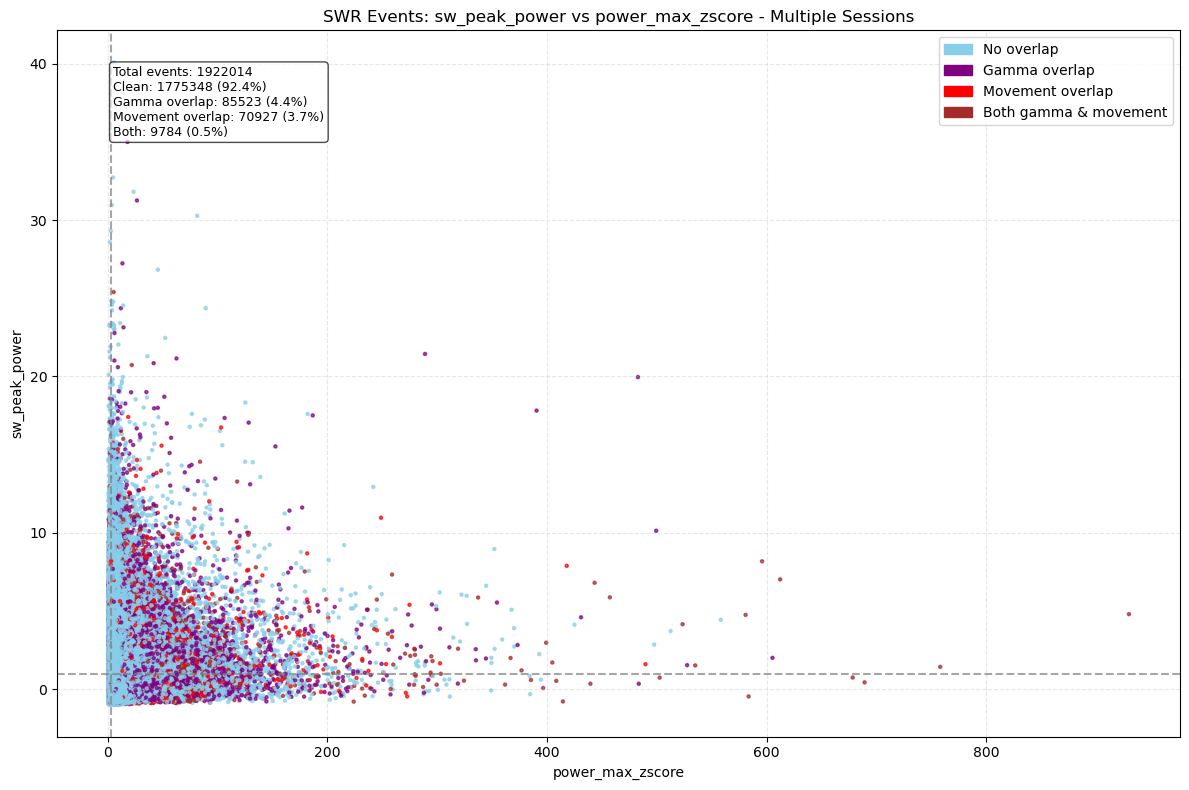

In [7]:
# Example usage:

fig, ax = plotter.plot_swr_events(
    "allen_visbehave_swr_murphylab2024",
    x_col='power_max_zscore', 
    y_col='sw_peak_power',
    x_threshold=3,
    y_threshold=1,
    plot_name="my_first_plot"
)


Number of events in the plot: 21795


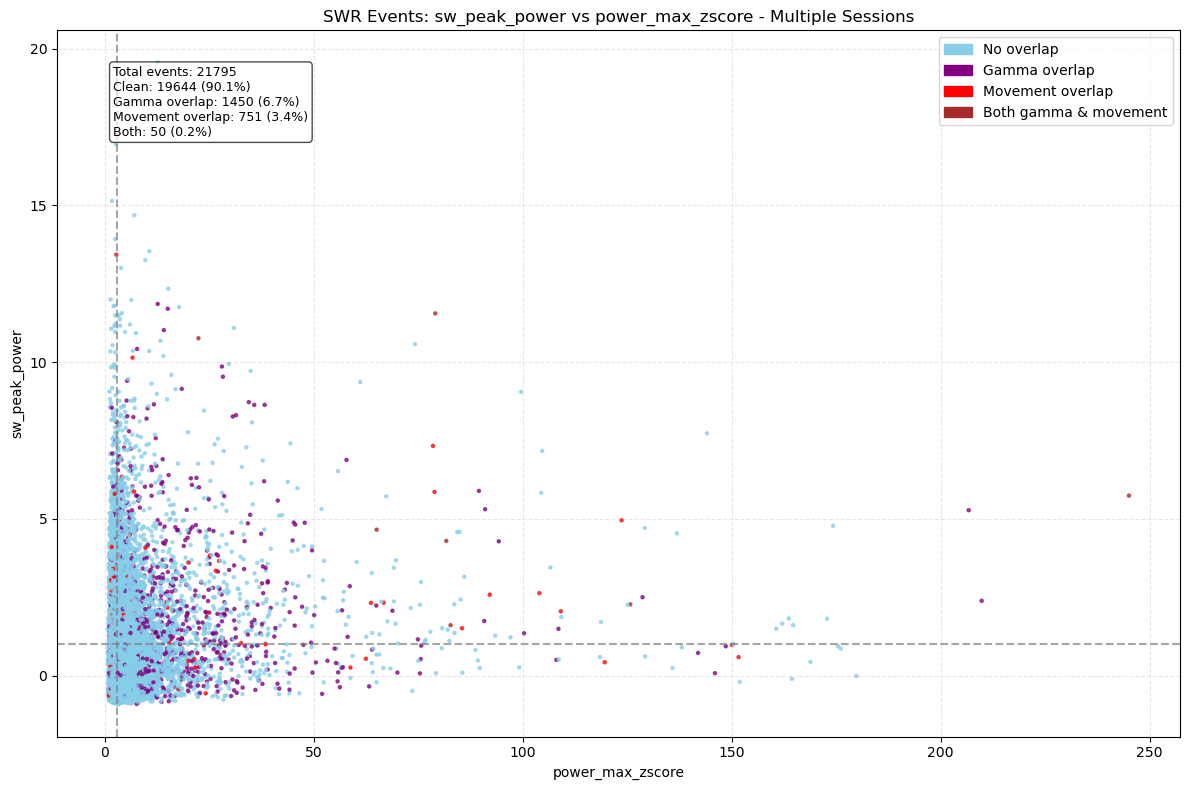

In [8]:


# Plot across specific sessions, note sessions must be in the same derived dataset
fig, ax = plotter.plot_swr_events(
    "allen_visbehave_swr_murphylab2024",
    ["1044385384", "1048196054"],
    x_col='power_max_zscore', 
    y_col='sw_peak_power',
    x_threshold=3,
    y_threshold=1,
    plot_name="my_first_plot"
)

# Access the data later
plot_data = plotter.get_plot_data("my_first_plot")
df = plot_data['data']
print(f"Number of events in the plot: {len(df)}")
plt.show()


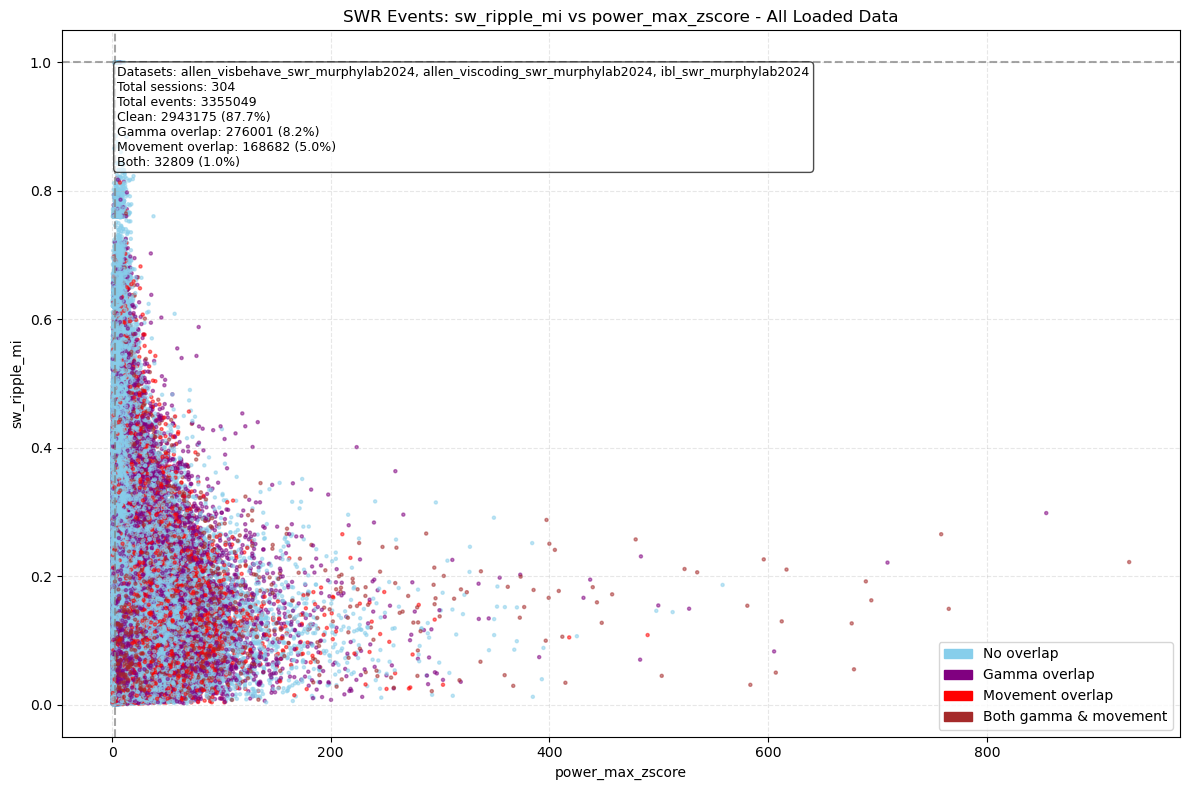

In [9]:
# Plot across ALL loaded data
fig, ax = plotter.plot_across_all_data(
    x_col='power_max_zscore', 
    y_col='sw_ripple_mi',
    x_threshold=2.5,
    y_threshold=1
)
# Access the scatter plot collections
for collection in ax.collections:
    # Reduce the size of the points
    collection.set_sizes([5])  # Change 10 to your preferred size (default was 50)
    # You can also adjust alpha if needed
    collection.set_alpha(0.5)  # Makes points more transparent

# Now show the plot
plt.show()



## Plot 2: Density Heatmap of Modulation Index vs. Ripple Power

The second plot presents a heatmap showing the density of events ranked by modulation index (the relationship between sharp wave phase and ripple amplitude) against ripple power. This visualization further demonstrates that **there is generally no good cutoff point** for defining SWRs.

However, it does reveal that events identified by our sharp wave peak power threshold tend to cluster in regions with **higher modulation indices**. This suggests that our threshold-based approach, while imperfect, does capture events that exhibit stronger SWR-like characteristics.

**Important Consideration**: While our threshold appears to select for events with higher modulation indices, we must acknowledge that there could be other confounding factors we are not aware of that influence this relationship.

**Things to try**  Try plotting this against the various other metircs we provide and see if interesting patterns emerge.  Or find differnces in regional spiking activity and try to label events that way.  

Data shape: (3355049, 29)
X-col (power_max_zscore) range: 0.26 to 930.13
Y-col (sw_ripple_mi) range: 0.00 to 1.00
X-col mean: 6.14, std: 7.51
Y-col mean: 0.17, std: 0.13
Auto-adjusted y_range to: (0.00, 0.45)


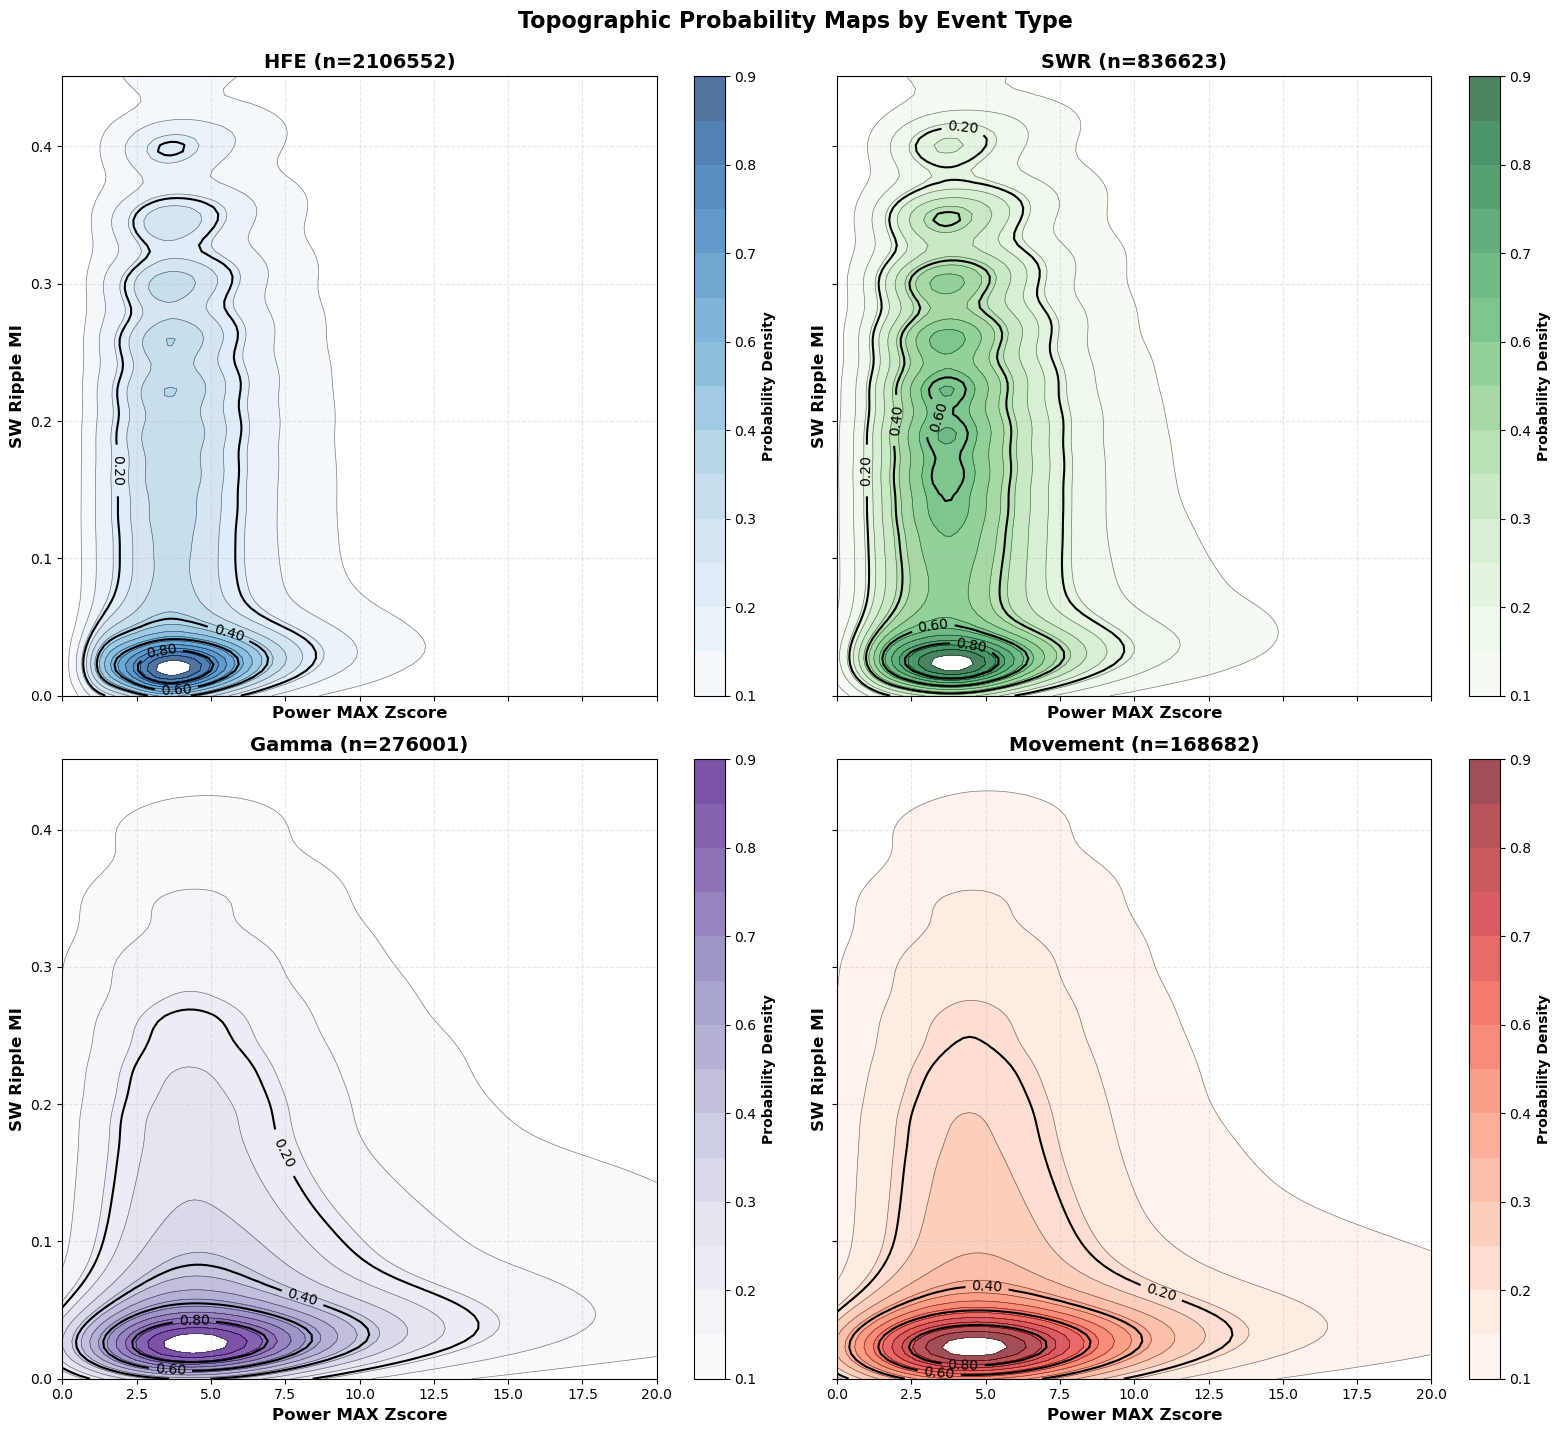

In [10]:
# Plot topographic probability maps across ALL loaded data
fig, axes = plotter.plot_topographic_probability_maps(
    x_col='power_max_zscore', 
    y_col='sw_ripple_mi',
    sw_peak_threshold=1,
    x_range=(0, 20),
    y_range=(0, 10),
    print_distribution_diagnostics = True
)

## Plot 3: Artifact Distribution

The final plot shows that confirmed artifacts make up a relatively low proportion of the overall distribution of putative events. This is encouraging, but it still leaves us with fundamental questions about threshold selection.

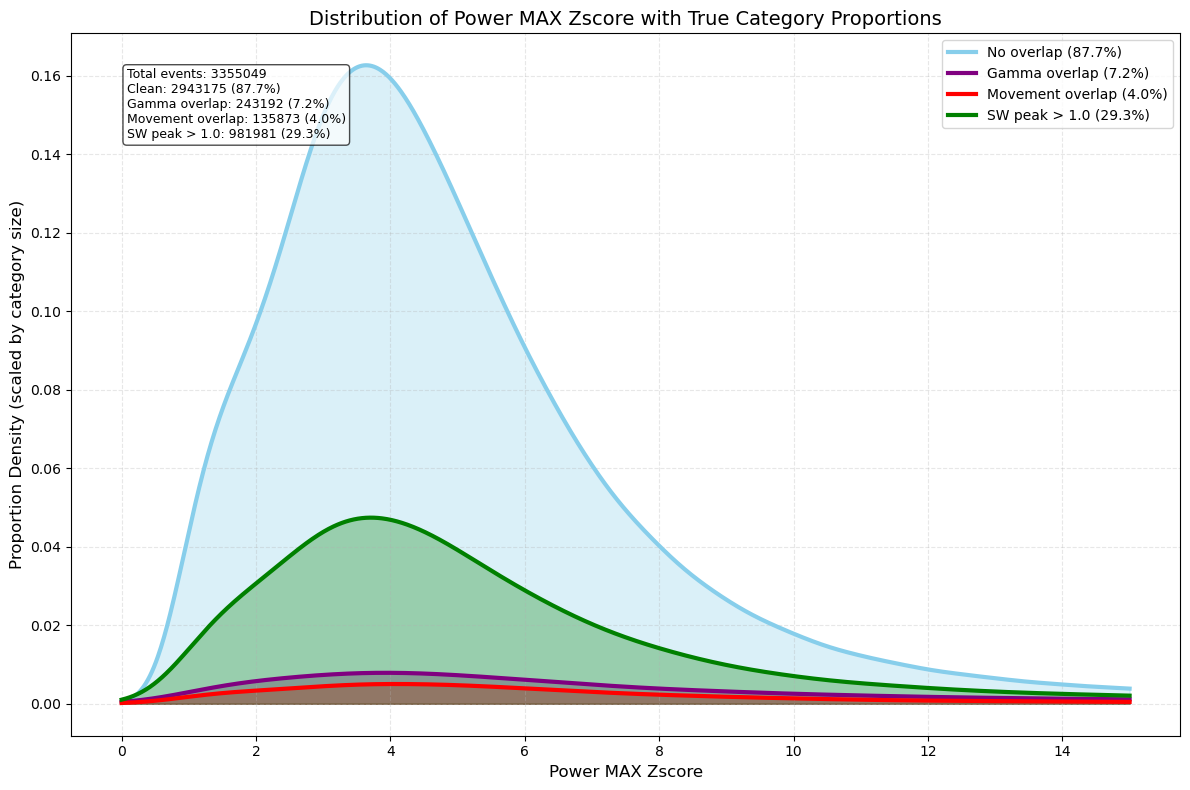

In [11]:
# Plot distribution by category
fig, ax = plotter.plot_distribution_by_category(
    x_col='power_max_zscore',
    x_range=(0, 15),
    sw_peak_threshold=1.0
)

## The Core Dilemma: Is a Discrete Definition Appropriate?

These visualizations force us to confront several critical questions:

1. **What is the "best" threshold?** Given the continuous nature of the data, any threshold we choose will be somewhat arbitrary and will inevitably include some events that might not be "true" SWRs while excluding others that might be.

2. **Is a discrete definition even appropriate?** The continuous distributions we observe suggest that SWRs may be better conceptualized as existing on a spectrum rather than as discrete, binary events.

3. **What are we actually measuring?** Our thresholds may be capturing events that are more "SWR-like" according to our chosen metrics, but this doesn't necessarily mean they represent the same underlying neural phenomenon.

## Implications for Analysis

This continuous nature of SWR definitions has important implications for how we interpret our results:

- **Threshold sensitivity**: Small changes in threshold values can significantly impact the number and characteristics of detected events
- **Reproducibility**: Different labs using different thresholds may be studying different subsets of the same underlying phenomenon
- **Interpretation**: We must be cautious about treating threshold-crossing events as equivalent to "true" SWRs

## Moving Forward

Rather than seeking the "perfect" threshold, we should:
- Acknowledge the inherent uncertainty in SWR detection
- Consider using multiple complementary detection methods
- Focus on the relative differences between conditions rather than absolute event counts
- Be transparent about our threshold choices and their limitations

## Towards SWR data standards and FAIR reporting of SWRs

The field of SWRs rarely shares their data, this publication is an attempt to extablish methods that could do so.  We used the largest available neuropixels datasets to develop a format for reporting them in a shareable manner that does not require sharing or processing LFP data which can be prohibitively time consuming.  While understanding of singal processing, high though put data analysis, and python development can be beneficial to analysing this in principle an undergraduate with a good intuition of these concepts should be able to use the data themselves and find insightful relations and phenomenon.  At the very least independent labs should be able to verify eachotehrs findings with minimal investment in time, compute, and patience.